### Carregando datasets

Assim como foi feito na etapa anterior(load_eeg), precisamos carregar os datasets para realizar o pré-processamento. O trecho a seguir é bem semelhante ao utilizado em load_eeg, tendo como principal diferença a geração da média entre os arquivos das diversas pastas, isso é feito para diminuir a quantidade de entrada no programa mantendo a confiabilidade dos dados e também para formatar os dados de forma que possam ser inseridos nas funções de pré-processamento(que exigem arrays 2D).

In [36]:
from re import search
import numpy as np
from subprocess import getoutput as gop
import glob
import pandas as pd
import csv
import mne

# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
}

def load_data(dataset):
    ch_names = []
    create_ch_name = False
    
    data_dir = gop('ls {}'.format(folders[dataset])).split('\n')
    # 1ª dimensão dos dados contendo os sujeitos
    subjects = list()
    subjects_alc = list()
    subjects_ctrl = list()
    
    for types in data_dir:
        files = gop('ls {}/{}'.format(folders[dataset], types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()
        is_alc = True
        
        for f in files:
            arquivo = open('{}/{}/{}'.format(folders[dataset], types, f))
            text = arquivo.readlines()
            
            alc = search('co2a', text[0])
            ctrl = search('co2c', text[0])
            
            if ctrl:
                is_alc = False
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            for line in text:
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
                                    
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())
            
            create_ch_name = True
            chs.append(values)
            trials.append(chs)
            arquivo.close()
            
        if is_alc:
            subjects_alc.append(trials)
            md_alc = np.average(trials, axis=0)
        else:
            subjects_ctrl.append(trials)
            md_ctrl = np.average(trials, axis=0)
    
    data_alc = np.array(subjects_alc)
    data_ctrl = np.array(subjects_ctrl)
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    
    aux = np.array(subjects_alc)
    subset = aux[-1, -1, :, :]
    
    raw = mne.io.RawArray(subset, info)
    raw.drop_channels(['x', 'nd', 'y'])
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    raw, _ = mne.set_eeg_reference(raw, 'average')
    raw.plot_psd(average=True)
    print('ISSO FAZ: ', raw)
    
    return data_alc, md_alc, data_ctrl, md_ctrl, ch_names

### Exibindo dados carregados

Aqui exibimos a forma(shape) dos dados carregados(large train e large test) que representam respectivamente: o número de experimentos, triagens, canais e amostras.
Também exibimos o shape das médias desses dados, como a média é feita entre os experimentos e triagens temos um shape que representa: canais, amostras.

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
Effective window size : 1.000 (s)


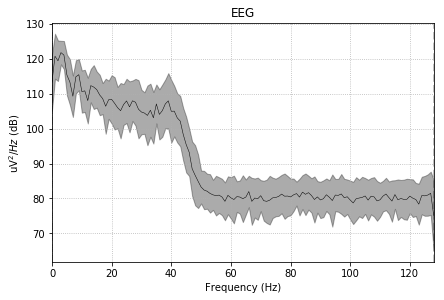

ISSO FAZ:  <RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~278 kB, data loaded>
**** Large Train ****

Alcoólatras:  (10, 30, 64, 256)
Controle:  (10, 30, 64, 256)
Média dos Alcoólatras:  (64, 256)
Média Controle:  (64, 256)

**** Fim Large Train ****

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
Effective window size : 1.000 (s)


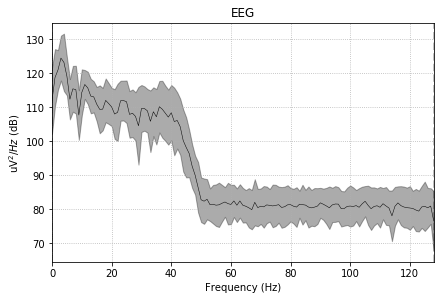

ISSO FAZ:  <RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~278 kB, data loaded>
**** Large Test ****

Alcoólatras:  (10, 30, 64, 256)
Controle:  (10, 30, 64, 256)
Média dos Alcoólatras:  (64, 256)
Média Controle:  (64, 256)

**** Fim Large Train ****



In [37]:
lg_train_alc, md_alc_train, lg_train_ctrl, md_ctrl_train, ch_names = load_data('large_train')
print('**** Large Train ****\n')
print('Alcoólatras: ', lg_train_alc.shape)
print('Controle: ', lg_train_ctrl.shape)
print('Média dos Alcoólatras: ', md_alc_train.shape)
print('Média Controle: ', md_ctrl_train.shape)
print('\n**** Fim Large Train ****\n')

lg_test_alc, md_alc_test, lg_test_ctrl, md_ctrl_test, ch_names = load_data('large_test')
print('**** Large Test ****\n')
print('Alcoólatras: ', lg_test_alc.shape)
print('Controle: ', lg_test_ctrl.shape)
print('Média dos Alcoólatras: ', md_alc_test.shape)
print('Média Controle: ', md_ctrl_test.shape)
print('\n**** Fim Large Train ****\n')

### Plotando gráfico nos dois domínios

Na sequência vamos plotar os dados médios dos eletrodos do arquivo preparado para visualizá-los no domínio do tempo e da frequência. Após visualizar, serão aplicados inicialmente filtros temporais e em seguida filtros espaciais. Aplicamos os filtros para que possamos observar com mais clareza a diferença entre os dados do dataset(alcoólicos e controle) e assim, decidir como proceder para a etapa de classificação.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne

def graphTimeFrequency(data, ch_names):
    # primeira sessão, primeiro trial
    x = data
    print(x.shape)

    ch_names = ch_names
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(x, info)

    # São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
    raw.drop_channels(['x', 'nd', 'y'])

    # Aplicamos a montagem do padrão 10-20 para todos os eletrodos
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)

    # Neste primeiro gráfico mostramos o sinal de um eletrodo no domínio do tempo
    plt.plot(np.linspace(0, 1, 256), raw.get_data()[0])
    plt.xlabel('tempo (s)')
    plt.ylabel('Dados EEG (mV/cm²)')

    # Aqui mostramos todos os 61 eletrodos que representam dados EEG
    raw.plot_psd()
    print()

*** Large Train ****

ALCOOÓLATRAS
(64, 256)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


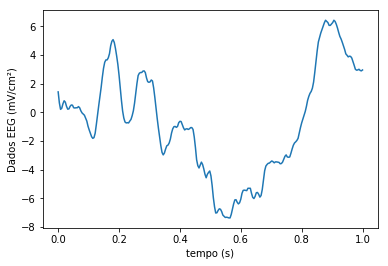

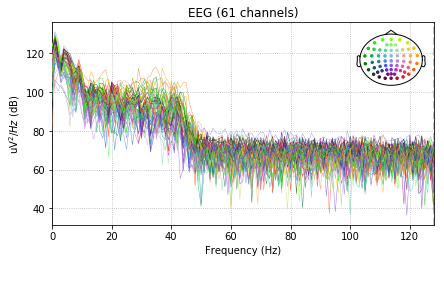


CONTROLE
(64, 256)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


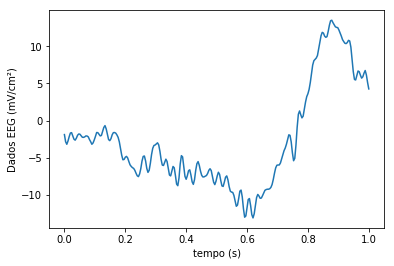

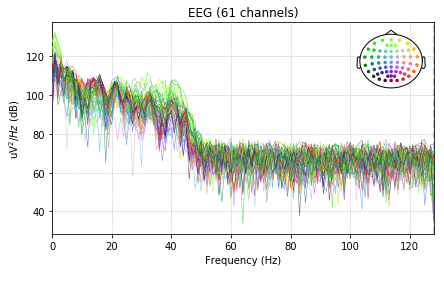


*** Fim Large Train ****

*** Large Test ****

ALCOOÓLATRAS
(64, 256)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


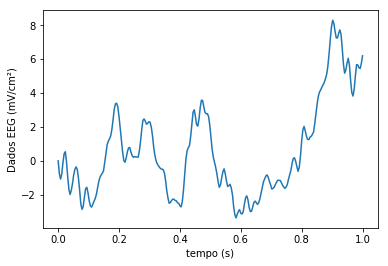

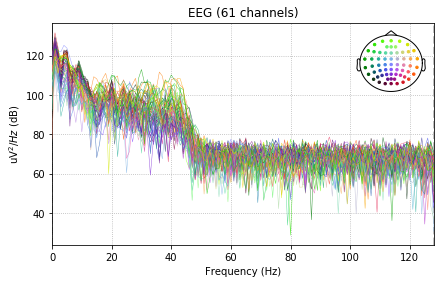


CONTROLE
(64, 256)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


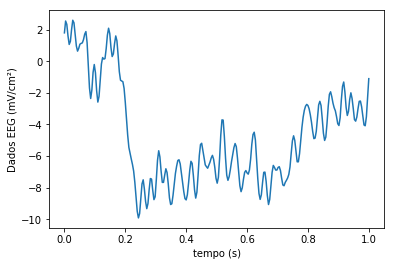

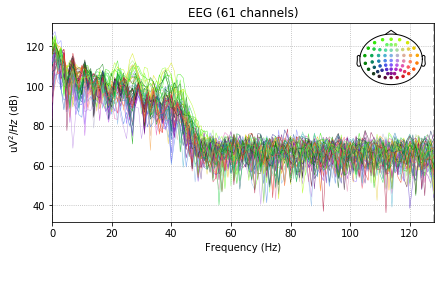


*** Fim Large Test ****



In [4]:
print("*** Large Train ****\n")
print("ALCOOÓLATRAS")
graphTimeFrequency(md_alc_train, ch_names)
print("CONTROLE")
graphTimeFrequency(md_ctrl_train, ch_names)
print("*** Fim Large Train ****\n")

print("*** Large Test ****\n")
print("ALCOOÓLATRAS")
graphTimeFrequency(md_alc_test, ch_names)

print("CONTROLE")
graphTimeFrequency(md_ctrl_test, ch_names)
print("*** Fim Large Test ****\n")